# Transfer Learning With Tensorflow Part 1: Feature Extraction

In [ ]:
!nvidia-smi

Wed Jul 20 20:51:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-07-20 20:51:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 142.251.45.16, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   238MB/s    in 0.7s    

2022-07-20 20:51:05 (238 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dir_path, dir, files in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dir)} directories and {len(files)} in {dir_path}')

There are 2 directories and 0 in 10_food_classes_10_percent
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 in 10_food_classes_10_percent/train/pizza
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_f

## Preparing Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

IMAGE_SHAPE = (224, 224)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE)

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow hub

We will try with 

* efficientnet/b0/feature-vector 
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


* imagenet/resnet_v2_50/feature_vector
https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

for comparison :)

In [ ]:
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
def create_model_from_url(model_url, num_classes=10):
  # Download pretrained model
  feature_extraction_layer = hub.KerasLayer(model_url,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE + (3,))
  
  # Create model
  model = tf.keras.Sequential([
    feature_extraction_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

## Creating and testing ResNet Tensorflow Hub Feature Extraction model

In [ ]:
resnet_model = create_model_from_url(resnet_url,
                                     num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name='Tensorflow_hub',
                                                                        experiment_name='resnet50v2')]
                                  )

Saving TensorBoard log files to: Tensorflow_hub/resnet50v2/20220720-214712
Epoch 1/5
24/24 [==============================] - 20s 719ms/step - loss: 2.0296 - accuracy: 0.3213 - val_loss: 1.2490 - val_accuracy: 0.6156
Epoch 2/5
24/24 [==============================] - 16s 671ms/step - loss: 0.9229 - accuracy: 0.7320 - val_loss: 0.8570 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 16s 670ms/step - loss: 0.6276 - accuracy: 0.8280 - val_loss: 0.7677 - val_accuracy: 0.7480
Epoch 4/5
24/24 [==============================] - 16s 669ms/step - loss: 0.4850 - accuracy: 0.8733 - val_loss: 0.7183 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 16s 674ms/step - loss: 0.3899 - accuracy: 0.9173 - val_loss: 0.6793 - val_accuracy: 0.7764


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=(15, 10))

  plt.subplot(1, 2, 1)
  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

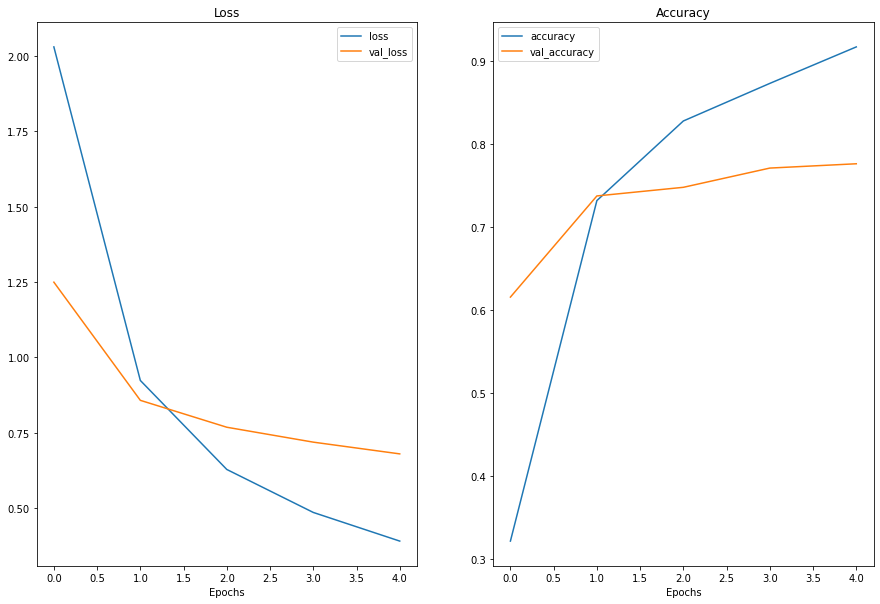

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [ ]:
efficientnet_model = create_model_from_url(efficientnet_url,
                                           train_data_10_percent.num_classes)

In [ ]:
efficientnet_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name='Tensorflow_hub',
                                                                                      experiment_name='efficientnetb0')])

Saving TensorBoard log files to: Tensorflow_hub/efficientnetb0/20220720-215206
Epoch 1/5
24/24 [==============================] - 25s 680ms/step - loss: 1.8883 - accuracy: 0.3947 - val_loss: 1.3103 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 15s 644ms/step - loss: 1.0676 - accuracy: 0.7840 - val_loss: 0.8727 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 15s 641ms/step - loss: 0.7616 - accuracy: 0.8413 - val_loss: 0.6985 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 15s 641ms/step - loss: 0.6118 - accuracy: 0.8720 - val_loss: 0.6133 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 15s 637ms/step - loss: 0.5190 - accuracy: 0.8867 - val_loss: 0.5583 - val_accuracy: 0.8608


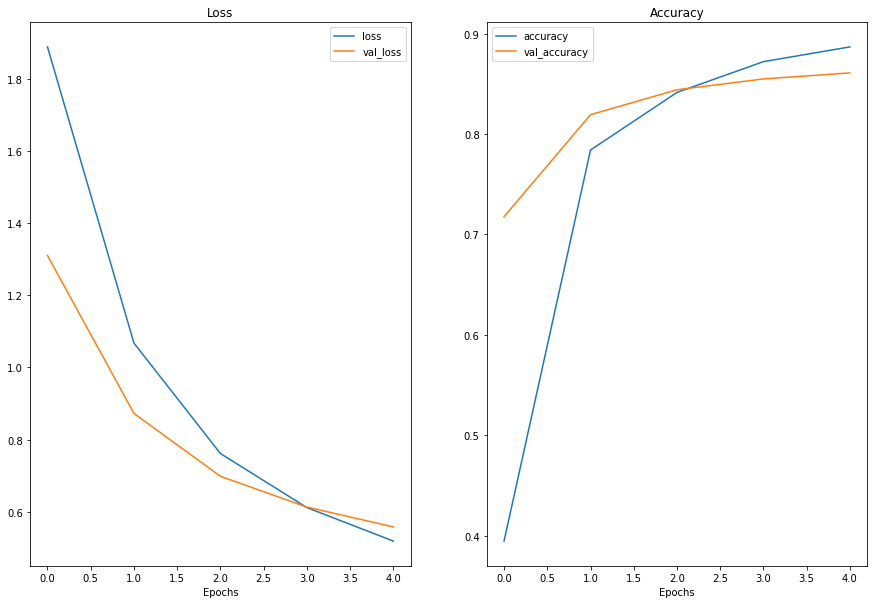

In [ ]:
plot_loss_curves(efficientnet_history)

## Comparing models using TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./Tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50v2" \
                        --description 'Comparing two models on the same data (that is actually 10% of our all data)' \
                        --one_shot

TensorBoard experiments are uploaded publically here:
* https://tensorboard.dev/experiment/w0gGSlNySWia3I24IlnvDg/

As we can see in the link, EfficientNet is crushing ResNet